In [5]:
import json
import os
import sklearn.metrics
import numpy as np
from pprint import pprint

In [6]:
def evaluate(tasks, berts, domains, runs=10, testing=None):
    for task in tasks:
        for bert in berts:
            for domain in domains:            
                for new_run in range(1, 10):
                    scores=[]
                    for run in range(1, runs+1):
                        DATA_DIR=os.path.join(task, domain)
                        if testing:
                            OUTPUT_DIR=os.path.join("run", bert+"_"+task, domain, str(run))
                        else:
                            OUTPUT_DIR=os.path.join("run", bert+"_"+task, domain, str(new_run), str(run))
                        if os.path.exists(os.path.join(OUTPUT_DIR, "predictions.json") ):
                            if "rrc" in task:
                                ret=!python eval/evaluate-v1.1.py $DATA_DIR/test.json $OUTPUT_DIR/predictions.json
                                score=json.loads(ret[0])
                                scores.append([score["exact_match"], score["f1"] ] )
                            elif "ae" in task:
                                ret=!python eval/evaluate_ae.py --pred_json $OUTPUT_DIR/predictions.json
                                scores.append(float(ret[0])*100 )
                            elif "asc" in task:
                                with open(os.path.join(OUTPUT_DIR, "predictions.json") ) as f:
                                    results=json.load(f)
                                y_true=results['label_ids']
                                y_pred=[np.argmax(logit) for logit in results['logits'] ]
                                p_macro, r_macro, f_macro, _=sklearn.metrics.precision_recall_fscore_support(y_true, y_pred, average='macro')
                                f_macro = 2*p_macro*r_macro/(p_macro+r_macro)
                                scores.append([100*sklearn.metrics.accuracy_score(y_true, y_pred), 100*f_macro ] )
                            else:
                                raise Exception("unknown task")
                    scores=np.array(scores)
                    m=scores.mean(axis=0)

                    if len(scores.shape)>1:
                        for iz, score in enumerate(m):
                            print(task, ":", bert, domain, "metric", iz, round(score, 2))
                            pprint(scores)
                            if testing:
                                np.savetxt(task + '_' + domain + '_ftb_test.csv', scores, delimiter=',')
                            else:
                                np.savetxt(str(new_run) + '_' + task + '_' + domain + '_ftb_valid.csv', scores, delimiter=',')
                    else:
                        np.savetxt(task + '_' + domain + '_ftb_test.csv', scores, delimiter=',')
                        print(task, ":", bert, domain, round(m,2))
                        pprint(scores)
                        break


In [ ]:
tasks = ["rrc"]
domains = ["laptop"]
berts

evaluate(tasks, berts, domains, runs, testing)

NameError: name 'tasks' is not defined

In [16]:
DATA_DIR = "../data/rrc/laptop"
OUTPUT_DIR = "../run/pt_rrc/20250319_bertbase_rrc_laptop"
runs = 10

for RUN in range(1, runs+1):
    ret=!python evaluate-v1.1.py $DATA_DIR/test.json $OUTPUT_DIR/$RUN/predictions.json
# score=json.loads(ret[0])
# scores.append([score["exact_match"], score["f1"] ] )
    ret=!python evaluate-v1.1.py $DATA_DIR/test.json $OUTPUT_DIR/2/predictions.json

print(ret)

[]


/home/tony/Documents/venvs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tony/Documents/venvs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


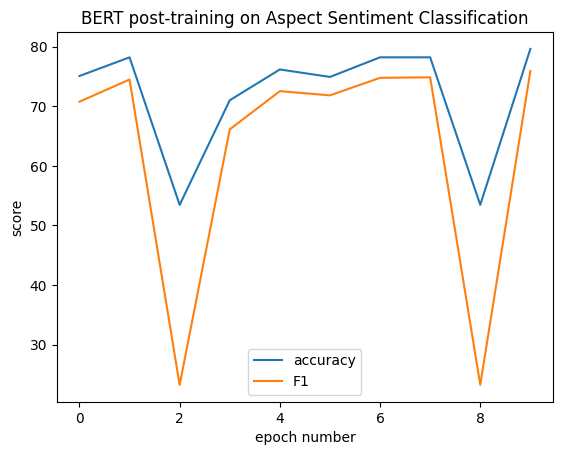

mean accuracy = 71.83385579937304 and mean F1 score = 62.773084521782756


In [4]:
# this works!

import matplotlib.pyplot as plt
import numpy as np

base_dir = "../run/pt_asc/laptop"
scores=[]

for i in range(1, 11):
    OUTPUT_DIR = os.path.join(base_dir, str(i))
    with open(os.path.join(OUTPUT_DIR, "predictions.json") ) as f:
        results=json.load(f)
        y_true=results['label_ids']
        y_pred=[np.argmax(logit) for logit in results['logits'] ]
        p_macro, r_macro, f_macro, _=sklearn.metrics.precision_recall_fscore_support(y_true, y_pred, average='macro')
        f_macro = 2*p_macro*r_macro/(p_macro+r_macro)
        scores.append([100*sklearn.metrics.accuracy_score(y_true, y_pred), 100*f_macro ] )

scores = np.array(scores)

plt.plot(scores[:, 0], label="accuracy")
plt.plot(scores[:, 1], label="F1")
plt.xlabel("epoch number")
plt.ylabel("score")
plt.title("BERT post-training on Aspect Sentiment Classification")
plt.legend()
plt.show()

print(f"mean accuracy = {np.mean(scores[:, 0])} and mean F1 score = {np.mean(scores[:, 1])}")

In [ ]:
import json

# load the ground truth
with open("../data/rrc/laptop/test.json", "r") as f:
    truth = json.load(f)

print(truth["data"][0]["paragraphs"][0]["qas"][0])



{'answers': [{'answer_start': 39, 'text': 'impressed'}], 'id': '30000_0', 'question': 'Do you like your new apple laptop ?'}


In [11]:

test_file = "../data/rrc/rest/test.json"
dumped_test_truth = "../data/rrc/rest/converted_test.json"

# load the ground truth
with open(test_file, "r") as f:
    truth = json.load(f)

truth_dict = {}
for each_data in truth["data"]:
    for each_paragraph in each_data["paragraphs"]:
        for each_qa in each_paragraph["qas"]:
            truth_dict[each_qa["id"]] = [i["text"] for i in each_qa["answers"]]

with open(dumped_test_truth, "w") as f:
    json.dump(truth_dict, f)



mean EM for 20250319_bertbase_rrc_laptop is 0.38461538461538464
mean EM for 202504070036_bertbase_rrc_laptop_to_rest is 0.36960556844547565
mean EM for 202504070110_bertbase_rrc_laptop_lr5e_5 is 0.40113960113960107
mean EM for 202504080023_bertbase_rrc_rest_laptop is 0.3361823361823361
mean EM for 202504080100_bertbase_rrc_rest is 0.4155452436194896


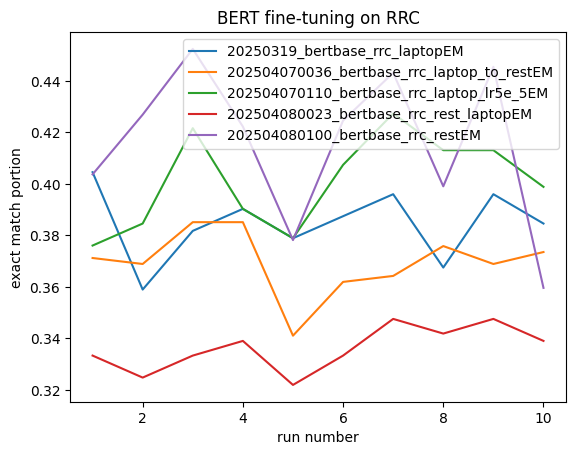

In [4]:
n_runs = 10

import json
import os
import matplotlib.pyplot as plt
import numpy as np

output_dirs = [
    # "../run/pt_rrc/20250319_bertlarge_rrc_laptop",
    # "../run/pt_rrc/20250319_bertbase_rrc_laptop",
    # "../run/pt_rrc/20250406_1845_bertbase_mse_lr5e_5",
    # "../run/pt_rrc/20250406_1818_bertbase_crossentropyloss/results",
    "../run/pt_rrc/laptop"
]

laptop_test_truth = "../data/rrc/laptop/converted_test.json"
rest_test_truth = "../data/rrc/rest/converted_test.json"

output_dir_and_dataset = [
    ["../run/pt_rrc/20250319_bertbase_rrc_laptop", laptop_test_truth],
    ["../run/pt_rrc/202504070036_bertbase_rrc_laptop_to_rest", rest_test_truth],
    ["../run/pt_rrc/202504070110_bertbase_rrc_laptop_lr5e_5", laptop_test_truth],
    ["../run/pt_rrc/202504080023_bertbase_rrc_rest_laptop", laptop_test_truth],
    ["../run/pt_rrc/202504080100_bertbase_rrc_rest", rest_test_truth]
]


runs = [i for i in range(1, n_runs+1)]

for output_dir, dumped_test_truth in output_dir_and_dataset:
    with open(dumped_test_truth, "r") as f:
        truth_dict = json.load(f)
    exact_matches = []
    f1_scores = []

    for i in runs: 
        OUTPUT_DIR = os.path.join(output_dir, str(i))
        with open(os.path.join(OUTPUT_DIR, "predictions.json") ) as f:
            results=json.load(f)
        exact_match = 0
        f1 = 0
        num_f1 = 0
        for each_key in truth_dict.keys():
            if results[each_key] in truth_dict[each_key]:# and len(results[each_key]) == len(truth_dict[each_key]):

                exact_match += 1
         

        exact_matches.append(exact_match/len(results))
        # f1_scores.append(f1/num_f1)



    plt.plot(runs, exact_matches, label=(output_dir.split("/")[-1] + "EM"))
    # plt.plot(runs, f1_scores, label=(output_dir.split("/")[-1] + "f1"))

    print(f"mean EM for {output_dir.split("/")[-1]} is {np.mean(exact_matches)}")
    # print(f"mean EM for {output_dir.split("/")[-1]} is {np.mean(f1_scores)}")


plt.legend()
plt.xlabel("run number")
plt.ylabel("exact match portion")
plt.title("BERT fine-tuning on RRC")
plt.show()


# print(f"mean accuracy = {np.mean(scores[:, 0])} and mean F1 score = {np.mean(scores[:, 1])}")

In [ ]:
from sklearn.metrics import f1_score


import json, os
""" Official evaluation script for v1.1 of the SQuAD dataset. """
from __future__ import print_function
from collections import Counter
import string
import re
import json
import sys


def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)

def evaluate(dataset, predictions):
    f1 = exact_match = total = 0
    for article in dataset:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                total += 1
                if qa['id'] not in predictions:
                    message = 'Unanswered question ' + qa['id'] + \
                              ' will receive score 0.'
                    print(message, file=sys.stderr)
                    continue
                ground_truths = list(map(lambda x: x['text'], qa['answers']))
                prediction = predictions[qa['id']]
                exact_match += metric_max_over_ground_truths(
                    exact_match_score, prediction, ground_truths)
                f1 += metric_max_over_ground_truths(
                    f1_score, prediction, ground_truths)

    exact_match = 100.0 * exact_match / total
    f1 = 100.0 * f1 / total

    return {'exact_match': exact_match, 'f1': f1}


DATA_DIR = "../data/rrc/laptop"
OUTPUT_DIR = "../run/pt_rrc/20250319_bertbase_rrc_laptop"
runs = 10

for RUN in range(1, runs+1):
    with open(os.path.join(OUTPUT_DIR, RUN, "prediction.json")) as js_file:
        predictions = json.load(js_file)
    with open(os.path.join(DATA_DIR, "test.json")) as js_file:
        truth = json.load(js_file)["data"]
    json.dumps(evaluate(predictions=predictions, dataset=truth))

ImportError: cannot import name 'evaluate' from 'evaluate_rrc' (/home/tony/Documents/github/BERT-for-RRC-ABSA/pytorch-pretrained-bert/eval/evaluate_rrc.py)

In [6]:
import json, os

test_file = "../data/rrc/rest/test.json"
dumped_test_truth = "../data/rrc/rest/converted_test.json"

# load the ground truth
with open(test_file, "r") as f:
    truth = json.load(f)

truth_dict = {}
for each_data in truth["data"]:
    for each_paragraph in each_data["paragraphs"]:
        for each_qa in each_paragraph["qas"]:
            truth_dict[each_qa["id"]] = [i["text"] for i in each_qa["answers"]]

print(len(truth_dict))

431
